In [1]:
import numpy as np 
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
import time 
import graph_tool as gt

from utils import PositivePart, Grid, ControlVolumes, VascularGraph, SplitVessels, gmres_counter

# Parameters

In [2]:
convertMicron = 1e-5

# Vessel parameters
vy = 2*50 * convertMicron # Length of the vessel, along the y-axis, in micron
r = 5 * convertMicron # Radius of the vessel, in micron
# Grid parameters
nx,ny,nz = 25,2*50,25      # Number of discretization point in each direction
lx,ly,lz = 50 * convertMicron, 2*100 * convertMicron, 50 * convertMicron # Cube's sides lengths, in micron
cx,cy,cz = -25 * convertMicron, -25 * convertMicron, -25 * convertMicron # Location of the bottom, left, back corner of the cube, in microns
h = lx/nx # Voxel size length
assert all(l/n==h for l,n in zip((lx,ly,lz), (nx,ny,nz))), f"Currently, the discretization assumes the voxels to be cubes (all sides must have the same length). Found {[l/n for l,n in zip((lx,ly,lz), (nx,ny,nz))]}"

# Physiological parameters
convertVolumetricFlow = (1e-6)/60 
q0 = 1e-1 * convertVolumetricFlow # 5 mu^3/min to L/s
Hd = 0.4 # Haematocrit 
C0 = 0.02 # Mol/L (What is that?)
# alpha = 1.2e-6 # Mol/L/mmHg, oxygen plasma solubility
alpha = 2.82e-5 * 1e3 # mlO2/mmHg/L from "Dynamic model of oxygen transport from capillaries to tissue with moving red blood cells." 
alpha_t = 3.89e-5 * 1e3 # mlO2/mmHg/L from "Dynamic model of oxygen transport from capillaries to tissue with moving red blood cells." 
Gamma_v = 1.77e3 * (convertMicron**2) # in mum2/s the permeability of the vessel wall to O2
h_v = 1 * convertMicron # In micons, the vessel wall thickness
Gamma_t = 1.8e3 * (convertMicron**2) # in mum2/s the oxygen diffusivity in tissue
k_t = 0.4 # 1/s, the oxygen consumption rates

# Boundary conditions
RO2 = 62.36 # Ideal gas constant for O2, L.mmHg/(K.Mol)
Tret = 308.15 # 35*C in Kelvin, the temperature of the retina (roughly)
cIn = 50 * alpha # mmHg to molO2/L = free plasma oxygen concentration
ctBC = 40 * alpha_t # / (RO2 * Tret)  # mmHg to molO2/L 

print(f"Boundary conditions: {cIn=}, {ctBC=}")
print(f"Dynamics parameters: {Gamma_t=}, {Gamma_v=}")
print(f"Vessel parameters: {r=}, {vy=}, {q0=}, {h_v=}")
print(f"Grid parameters: {(lx,ly,lz)=}, {(cx,cy,cz)=}, {h=}")

Boundary conditions: cIn=1.41, ctBC=1.5559999999999998
Dynamics parameters: Gamma_t=1.8000000000000002e-07, Gamma_v=1.7700000000000004e-07
Vessel parameters: r=5e-05, vy=0.001, q0=1.6666666666666667e-09, h_v=1e-05
Grid parameters: (lx,ly,lz)=(0.0005, 0.002, 0.0005), (cx,cy,cz)=(-0.00025, -0.00025, -0.00025), h=2e-05


In [3]:
print(f"{Gamma_v/(q0*h_v)=}")
print(f"Intravascular inlet O2 concentratioN: {cIn=}")
print(f"Tissue O2 concentration (boundary condition): {ctBC=}")
print(f"{Gamma_t/k_t=}")
print(f"{22.4*alpha=}, {1/(RO2*Tret)=}")

Gamma_v/(q0*h_v)=10620000.000000002
Intravascular inlet O2 concentratioN: cIn=1.41
Tissue O2 concentration (boundary condition): ctBC=1.5559999999999998
Gamma_t/k_t=4.5000000000000003e-07
22.4*alpha=0.6316799999999999, 1/(RO2*Tret)=5.203933299313488e-05


# Test convection

### Create vessel graph

In [4]:
p0 = np.array([0.0,0,0.0]) 
p1 = np.array([0.0,vy,0.0]) 
n = (p1-p0)/np.linalg.norm(p0-p1, 2)
l = np.linalg.norm(p0-p1, 2)
k = 3

VAG = VascularGraph()
VAG.add_edge_list([(i,i+1,l/k, r) for i in range(k)], eprops=[('length', 'float'), ('radius','float')])
pos = VAG.new_vertex_property("vector<double>")
pos.set_2d_array(np.array([p0+t*(p1-p0) for t in np.linspace(0,1,endpoint=True, num=k+1)]).T)

VAG.vp['position'] = pos
VAG.vp['plexus'] = VAG.new_vertex_property("int", val=0)
VAG.vp['sort'] = VAG.new_vertex_property('int', vals=gt.topology.topological_sort(VAG))

# gt.draw.graph_draw(VAG, pos=VAG.vp['position'])
CV = ControlVolumes(Grid(origin=(cx,cy,cz), 
                         sideLengths=(lx,ly,lz), 
                         shape=(nx,ny,nz)), 
                         vessels=VAG)

In [5]:
print([np.array(p)/convertMicron for p in VAG.vp['position']])

[array([0., 0., 0.]), array([ 0.        , 33.33333333,  0.        ]), array([ 0.        , 66.66666667,  0.        ]), array([  0., 100.,   0.])]


### Split to mesh size

In [6]:
SplitVessels(CV, CV.grid.h)
q = CV._vessels.new_edge_property("float", q0) # Flow in the vessel (constant -- conservation of mass)
CV._vessels.ep['q'] = q

Refining vascular mesh: 100%|██████████| 3/3 [00:00<00:00, 1229.28edges/s]


### Label

In [7]:
coupling = CV.LabelMesh(h_v)
# CV.ToVTK("LabelGridOneVessel.vtk")

Pruning the coupling graph: 100%|██████████| 1691/1691 [00:00<00:00, 227815.12it/s]


In [8]:
def ConvectionMatrices(CV):
    C1 = gt.spectral.incidence(CV._vessels).T
    Din = sp.dia_matrix(((CV._vessels.get_in_degrees(list(CV._vessels.iter_vertices()))==0).astype(int), 0),
                        shape=(CV._vessels.num_vertices(), CV._vessels.num_vertices()))
    Dout = sp.dia_matrix(((CV._vessels.get_out_degrees(CV._vessels.get_vertices())==0).astype(int), 0),
                        shape=(CV._vessels.num_vertices(), CV._vessels.num_vertices()))    
    q = CV._vessels.ep['q']
    l = CV._vessels.ep['length']
    L = sp.dia_matrix((1.0/l.a, 0), shape=2*[CV._vessels.num_edges()])
    Q = sp.dia_matrix((q.a * (l.a/2), 0), shape=2*[CV._vessels.num_edges()])
    Min  = Din @ C1.T @ Q @ (PositivePart(-C1))
    MOut = Dout @ C1.T @ Q @ PositivePart(C1)
    M = C1.T@(PositivePart(L@Q)@PositivePart(C1) - PositivePart(-L@Q)@PositivePart(-C1))
    # M -= MOut
    return M.T.tocsr(), Min.T.tocsr(), Din.tocsr()


In [9]:
def SurfaceArea(CV):
    S = np.pi*CV._vessels.ep['radius'].a*(CV._vessels.ep['length'].a/2) 
    C1 = gt.spectral.incidence(CV._vessels)
    S = abs(C1)@S
    S = sp.dia_matrix((S, 0), shape=2*[CV._vessels.num_vertices()])
    return S

## Toy convection problem
-(v*Vc)'-Gamma_v/h_v S c = 0 

In [10]:
M, Min, Din = ConvectionMatrices(CV)
Convection = M + Min
S = SurfaceArea(CV)
Reaction   = Gamma_v /h_v * S@(sp.eye(M.shape[0])-Din)
cvBar = Din@(cIn * Min @ np.ones(M.shape[1]))

x = spl.spsolve(Convection + Reaction, cvBar)

In [11]:
# Solution 
def ExactSol(x):
    return cIn * np.exp(-Gamma_v/(h_v*CV._vessels.ep['q'].a[0]) * 2*np.pi*r*x)

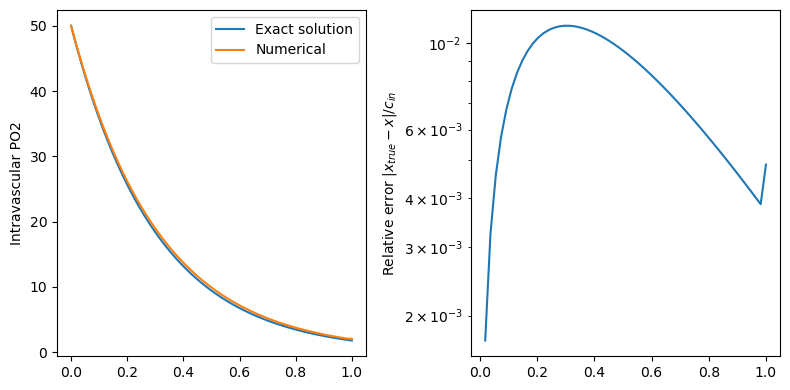

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy
ax1.plot(s, ExactSol(s*vy)/alpha, label='Exact solution')
ax1.plot(s, x/alpha, label='Numerical')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")

ax2.semilogy(s[1:], abs(ExactSol(s*vy)-x)[1:]/cIn)
ax2.set_ylabel(r"Relative error $|x_{true}-x|/c_{in}$")
fig.tight_layout()
plt.show()

### Adding surrounding tissue sinks manually
Solving -qc'-Gamma_v*S/h_v(c-ct)=0

In [13]:
S = SurfaceArea(CV)

ctBC = 0.6 * cIn

M, Min, Din = ConvectionMatrices(CV)
Convection = M + Min
Reaction   = Gamma_v * S/h_v * (sp.eye(M.shape[0])-Din)

cvBar = Din@(cIn * Min @ np.ones(M.shape[1])) + Reaction @ (np.ones(Reaction.shape[1])*ctBC)

x = spl.spsolve(Convection + Reaction, cvBar)

In [14]:
def ExactSol(s, c0=cIn, ct=ctBC):
    print(f"{c0/alpha=}, {ct/alpha=}")
    # pi*r^2*s = S
    return ct + (c0-ct)*np.exp(-Gamma_v/(h_v*q0)*2*np.pi*r*s)

c0/alpha=50.0, ct/alpha=30.0


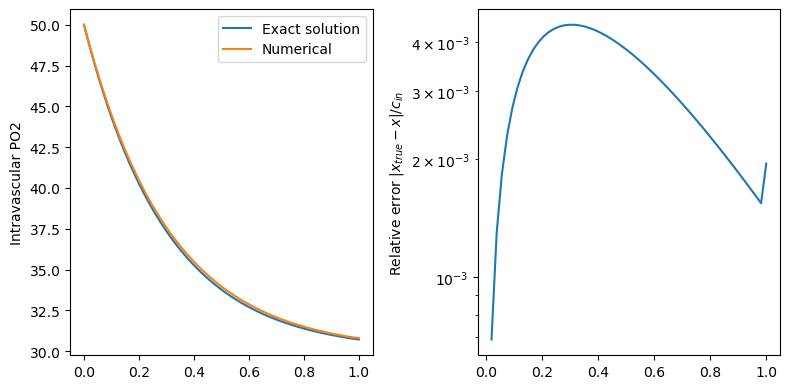

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy

xtrue = ExactSol(s*vy)

ax1.plot(s, xtrue/alpha, label='Exact solution')
ax1.plot(s, x/alpha, label='Numerical')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")

ax2.semilogy(s[1:], abs(xtrue-x)[1:]/cIn)
ax2.set_ylabel(r"Relative error $|x_{true}-x|/c_{in}$")
fig.tight_layout()
plt.show()

# Testing with real tissue
### Tissue equations forced to constant

In [16]:
# import itertools 

# def MakeCSRBinaryMatrix(data, nrows:int, ncols:int):
#     '''
#     Quickly assemble a CSR matrix where the non-zero elements for each row are
#     given by their column number.

#     ### Parameters
#     - data: list[list[int]]
#         The non-zero elements of the matrix. 
#         Each list correspond to a row and contains the column number of the nnz entry.
#     - nrows, ncols: int
#         The number of rows and columns of the matrix.
#     '''
#     # indices = np.concatenate(data)
#     indices = np.fromiter(itertools.chain.from_iterable(data), dtype=np.int32)
#     # row_indices = np.repeat(np.arange(len(data)), [len(row) for row in data])
#     values = np.ones_like(indices)
#     indptr = np.concatenate([[0], np.cumsum(np.array([len(row) for row in data]))])    
#     return sp.csr_matrix((values, indices, indptr), shape=(nrows,ncols))

# def ControlVolumesProjectionMatrices(CV:ControlVolumes):
#     endoToVoxel = [l for l in CV.VAG.vp['endothelium']]
#     C2t = MakeCSRBinaryMatrix(endoToVoxel, nrows=CV.VAG.num_vertices(), 
#         ncols=CV.grid.size)
#     C2v = MakeCSRBinaryMatrix([[v] for v in CV.VAG.get_vertices()], nrows=CV.VAG.num_vertices(), 
#         ncols=CV._vessels.num_vertices())
#     return C2v, C2t
# C2v, C2t = ControlVolumesProjectionMatrices(CV)
# print(C2v.shape, C2t.shape)

### Scale S by number of connected tissue voxels 

In [17]:
# def SurfaceArea(CV):
#     # N = np.asarray([len(l) for l in CV.VAG.vp['endothelium']])
#     # N = np.where(N!=0, 1/N, 0)
#     S = np.pi*CV._vessels.ep['radius'].a*(CV._vessels.ep['length'].a/2) 
#     C1 = gt.spectral.incidence(CV._vessels)
#     S = abs(C1)@S
#     # S = np.multiply(N, abs(C1)@S)
#     # S = sp.dia_matrix((S, 0), shape=2*[CV._vessels.num_vertices()])
#     return S

In [18]:
# endo = gt.util.find_edge(coupling, coupling.ep['eType'], 1)
# C2v = sp.dok_matrix((CV.VAG.num_vertices(), len(endo)))
# C2t = sp.dok_matrix((CV.grid.size, len(endo)))
# N   = np.zeros(CV.VAG.num_vertices(), dtype=int)
# for i, e in enumerate(endo): 
#     u,v = int(e.source()), int(e.target()) 
#     C2v[u,i] = 1
#     N[u]+=1
#     C2t[v, i] = 1
# C2v, C2t = C2v.tocsr().T, C2t.tocsr().T
# s = SurfaceArea(CV)
# s = np.multiply(1/N, s)
# S = sp.dia_matrix(([si for si,Ni in zip(s, N) for _ in range(Ni)],0), shape=2*[sum(N)])

In [19]:
# B = sp.eye(CV.grid.size)
# G = sp.csr_matrix((CV.grid.size, CV._vessels.num_vertices()))

# A = Convection + Gamma_v/h_v * C2v.T @ S @ C2v @ (sp.eye(M.shape[0])-Din)
# E = -Gamma_v/h_v * (sp.eye(M.shape[0])-Din) @ C2v.T@S@C2t

# cvBar = Din@(cIn * Min @ np.ones(M.shape[1])) 
# ctBar = np.ones(CV.grid.size) * ctBC

In [20]:
# # K = A
# # y = -E@ctBar + cvBar 
# K = sp.bmat([[A,E], [G,B]]).tocsc()
# y = np.hstack([cvBar, ctBar])

# # with gmres_counter(disp=1) as callback:
# #     x, code = spl.gmres(K, y, callback=callback, maxiter=1000)
# x = spl.spsolve(K, y)
# # print("Exited with code:", code)

In [21]:
# cv, ct = x[:CV._vessels.num_vertices()], x[CV._vessels.num_vertices():]

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
# s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy

# xtrue = ExactSol(s*vy)

# ax1.plot(s, xtrue/alpha, label='Exact solution')
# ax1.plot(s, cv/alpha, label='Numerical')
# ax1.legend()
# ax1.set_ylabel("Intravascular PO2")

# ax2.semilogy(s[1:], abs(xtrue-cv)[1:]/cIn)
# ax2.set_ylabel(r"Relative error $|x_{true}-x|/c_{in}$")
# fig.tight_layout()
# plt.show()

### Real problem

In [22]:
from LinearSystems import MakeCouplingMatrices, MakeAll

In [23]:
lat = gt.generation.lattice(CV.grid.shape)
lat.set_directed(True)
C3 = gt.spectral.incidence(lat)
D3 = sp.dia_matrix(([d!=6 for d in lat.get_total_degrees(lat.get_vertices())], 0), shape=(CV.grid.size, CV.grid.size))
I3 = sp.eye(CV.grid.size)
C2v, C2t, S = MakeCouplingMatrices(CV, h_v)

Pruning the coupling graph: 100%|██████████| 1691/1691 [00:00<00:00, 208531.34it/s]


In [24]:
# B = (I3-D3)@(-Gamma_t * (CV.grid.h[0]) * C3@C3.T + k_t * np.prod(CV.grid.h) * I3) + D3
# B -= Gamma_v/h_v * C2t.T@S@C2t
# G = Gamma_v/h_v * C2t.T @ S @ C2v #@ (sp.eye(M.shape[0])-Din)

# A = Convection + Gamma_v/h_v * C2v.T @ S @ C2v @ (sp.eye(M.shape[0])-Din)
# E = -Gamma_v/h_v * (sp.eye(M.shape[0])-Din) @ C2v.T@S@C2t

[[A,E], [G,B]], [cvBar, ctBar] = MakeAll(CV, C2v, C2t, S, cIn, ctBC, Gamma_v, h_v, 100*Gamma_t, k_t)

A[0,0] = 1
cvBar[0] = cIn
# cvBar = Din@(cIn * Min @ np.ones(M.shape[1])) 
# ctBar = D3 @ np.ones(CV.grid.size) * ctBC

A, done. CPU: svmem(total=67214938112, available=61235970048, percent=8.9, used=5128683520, free=60299296768, active=4214415360, inactive=1293086720, buffers=73527296, cached=1713430528, shared=103317504, slab=744652800)
E, done. CPU: svmem(total=67214938112, available=61235462144, percent=8.9, used=5129191424, free=60298788864, active=4214415360, inactive=1293086720, buffers=73527296, cached=1713430528, shared=103317504, slab=744652800)
Got diffusion. CPU: svmem(total=67214938112, available=61235462144, percent=8.9, used=5129191424, free=60298788864, active=4214415360, inactive=1293086720, buffers=73527296, cached=1713430528, shared=103317504, slab=744652800)
B, done. CPU: svmem(total=67214938112, available=61235462144, percent=8.9, used=5129191424, free=60298788864, active=4214415360, inactive=1293086720, buffers=73527296, cached=1713430528, shared=103317504, slab=744652800)
G, done. CPU, svmem(total=67214938112, available=61235462144, percent=8.9, used=5129191424, free=60298788864, 

In [25]:
y = np.hstack([cvBar, ctBar])
nCV, nT = cvBar.shape[0], ctBar.shape[0]
def mv(v):
    return np.hstack(
        (A@v[:nCV]+E@v[nCV:],
         -G@v[:nCV]+B@v[nCV:])
        )
K = spl.LinearOperator((nCV+nT, nCV+nT), matvec=mv)

x, code = spl.bicgstab(K, y, tol=1e-18, callback=gmres_counter(1), maxiter=1000) #spl.gmres(K, y, maxiter=1000, tol=1e-18, callback=gmres_counter(10))
print("Exited with code", code)

iter   1	rk = 0.8452651906323425
iter   2	rk = 0.8452781329466602
iter   3	rk = 0.8458434561708364
iter   4	rk = 0.84579676649302
iter   5	rk = 0.8460089556210909
iter   6	rk = 0.8460124143843127
iter   7	rk = 0.8461607868803712
iter   8	rk = 0.8461607868834014
iter   9	rk = 0.8461607950395564
iter  10	rk = 0.8461660663688606
iter  11	rk = 0.8461665874170213
iter  12	rk = 0.8461665877674307
iter  13	rk = 0.8461665877799542
iter  14	rk = 0.8461570784883711
iter  15	rk = 0.8461577423133287
iter  16	rk = 0.8461577423027147
iter  17	rk = 0.8461577423024338
iter  18	rk = 0.8461577423030888
iter  19	rk = 0.8461577423032203
iter  20	rk = 0.8461577422875792
iter  21	rk = 0.8461577838342655
iter  22	rk = 0.8461577839364717
iter  23	rk = 0.84615813634558
iter  24	rk = 0.8464920646947196
iter  25	rk = 0.8464785925793799
iter  26	rk = 0.8463913641950096
iter  27	rk = 0.8463913639932786
iter  28	rk = 0.8460534342288029
iter  29	rk = 0.8460519432100685
iter  30	rk = 0.8460583511394191
iter  31	rk = 

In [26]:
# K = sp.bmat([[A,E], [G,B]]).tocsc()
# y = np.hstack([cvBar, ctBar])

# # with gmres_counter(disp=1) as callback:
# #     ynorm = np.linalg.norm(y)
# #     # K/=ynorm
# #     # y/=ynorm
# #     x, code = spl.gmres(K, y, x0=ctBC + np.zeros_like(y), callback=callback, atol=1e-10, maxiter=10000)
# # print("Exited with code:", code)
# x = spl.spsolve(K, y)


c0/alpha=50.0, ct/alpha=30.0
31.028087827226297


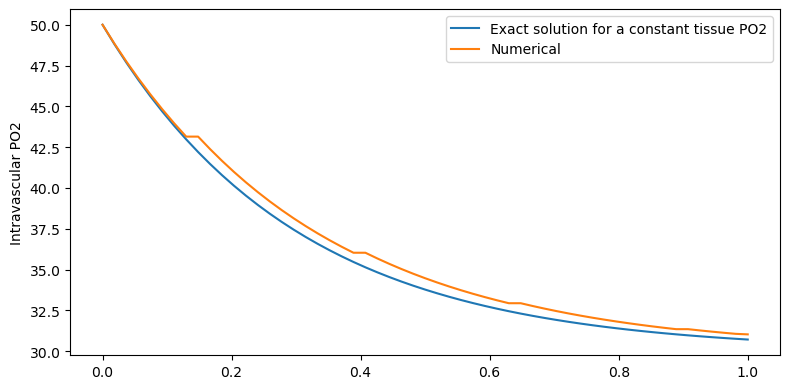

In [27]:
cv, ct = x[:CV._vessels.num_vertices()], x[CV._vessels.num_vertices():]

fig, ax1 = plt.subplots(1,1, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy

xtrue = ExactSol(s*vy)

ax1.plot(s, xtrue/alpha, label='Exact solution for a constant tissue PO2')
ax1.plot(s, cv/alpha, label='Numerical')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")
print(cv.min()/alpha)
# ax2.semilogy(s[1:], abs(xtrue-cv)[1:]/cIn)
# ax2.set_ylabel(r"Relative error $|x_{true}-x|/c_{in}$")
fig.tight_layout()
plt.show()

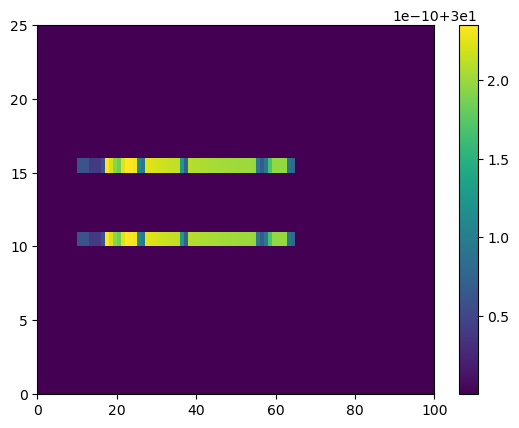

In [28]:
import matplotlib
plt.pcolormesh(ct.reshape(CV.grid.shape)[:, :, int(nz/2)]/alpha)#, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

# Real equations

In [29]:
CV = ControlVolumes(Grid(origin=(cx,cy,cz), 
                         sideLengths=(lx,ly,lz), 
                         shape=(nx,ny,nz)), 
                         vessels=VAG)
SplitVessels(CV, CV.grid.h)
q = CV._vessels.new_edge_property("float", q0) # Flow in the vessel (constant -- conservation of mass)
CV._vessels.ep['q'] = q
print(f"{CV.grid.size=}")

Refining vascular mesh: 100%|██████████| 3/3 [00:00<00:00, 3661.02edges/s]

CV.grid.size=62500


Pruning the coupling graph: 100%|██████████| 1691/1691 [00:00<00:00, 213947.33it/s]

A, done. CPU: svmem(total=67214938112, available=61234065408, percent=8.9, used=5126451200, free=60297195520, active=4214304768, inactive=1293283328, buffers=73641984, cached=1717649408, shared=107425792, slab=744652800)
E, done. CPU: svmem(total=67214938112, available=61234065408, percent=8.9, used=5126451200, free=60297195520, active=4214304768, inactive=1293283328, buffers=73641984, cached=1717649408, shared=107425792, slab=744652800)
Got diffusion. CPU: svmem(total=67214938112, available=61234065408, percent=8.9, used=5126451200, free=60297195520, active=4214304768, inactive=1293283328, buffers=73641984, cached=1717649408, shared=107425792, slab=744652800)
B, done. CPU: svmem(total=67214938112, available=61234065408, percent=8.9, used=5126451200, free=60297195520, active=4214304768, inactive=1293283328, buffers=73641984, cached=1717649408, shared=107425792, slab=744652800)
G, done. CPU, svmem(total=67214938112, available=61234065408, percent=8.9, used=5126451200, free=60297195520, 

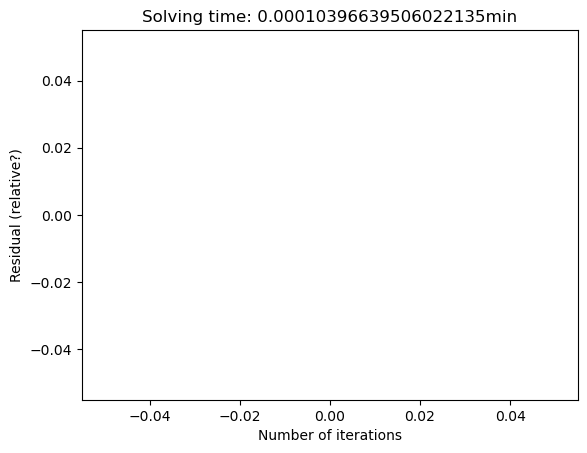

In [30]:
from LinearSystems import MakeCouplingMatrices, MakeAll
C2v, C2t, S = MakeCouplingMatrices(CV, h_v)
nCV, nT = CV._vessels.num_vertices(), CV.grid.size

K, y = MakeAll(CV, C2v, C2t, S, cIn, ctBC, 
               Gamma_t=Gamma_t, Gamma_v=Gamma_v, h_v=h_v, k_t=k_t)
# K = sp.bmat(K).tocsr()
y = np.hstack(y)
def mv(v):
    return np.hstack(
        (K[0][0]@v[:nCV]+K[0][1]@v[nCV:],
         K[1][0]@v[:nCV]+K[1][1]@v[nCV:])
        )
A = spl.LinearOperator((nCV+nT, nCV+nT), matvec=mv)

with gmres_counter() as callback:
    x, code = spl.gmres(A, y, callback=callback, maxiter=2000)
    print("Exited with code", code)
# x = spl.spsolve(K,y)

try:
    oldcv = cv.copy()
except NameError:
    pass
cv, ct = x[:CV._vessels.num_vertices()], x[CV._vessels.num_vertices():]

0.0


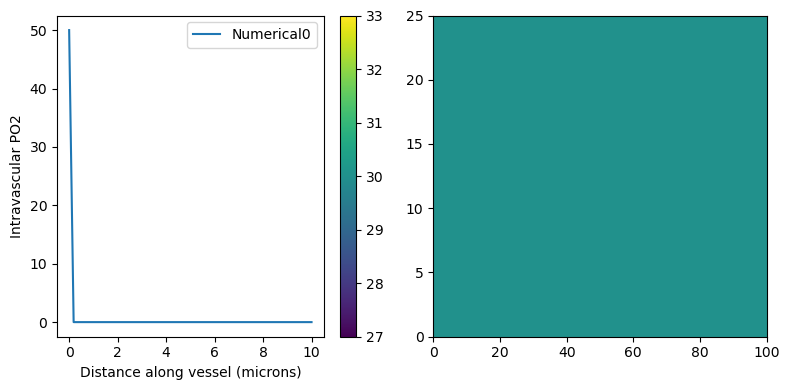

In [31]:
print(cv.min()/alpha)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy

# ax1.plot(s, xtrue/alpha, label='Exact solution')
ax1.plot(1e4*s*vy, cv/alpha, label='Numerical0')
# ax1.plot(s*vy, oldcv/alpha, label='Numerical1')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")
ax1.set_xlabel("Distance along vessel (microns)")

cm = ax2.pcolormesh(ct.reshape(CV.grid.shape)[:, :, int(nz/2)]/alpha)
fig.colorbar(cm, ax=ax1)
fig.tight_layout()
plt.show()

oldcv = cv

# On real graph

In [32]:
from LinearSystems import MakeCouplingMatrices, MakeAll

In [33]:
VAG = VascularGraph("/home/remi/Desktop/IOVS-Paper-Varying-alpha/UQ/Haemodynamics-100OPP-1e6R-0.4alpha/sim_18_AV.graph")
lx, ly, lz = [1e4*x * convertMicron for x in (.3,.3,.02)]
VAG.vp['position'].set_2d_array(VAG.vp['position'].get_2d_array((0,1,2))*1e4 * convertMicron)
VAG.ep['radius'].a *= 1e4 * convertMicron
VAG.ep['length'].a *= 1e4 * convertMicron

nx,ny,nz = (100,200,200)
CV = ControlVolumes(Grid((-lx/2, -ly/2, -lz), (lx,ly,lz*1.2), (nx,ny,nz)), VAG)
CV._vessels.ep['q'] = CV._vessels.new_edge_property("float", VAG.ep['flow'].a * 1e-3)

In [34]:
SplitVessels(CV, CV.grid.h)

Refining vascular mesh: 100%|██████████| 60236/60236 [00:03<00:00, 16620.37edges/s]


In [35]:
h_v, CV.grid.h, CV._vessels.ep['radius'].a.min()

(1e-05,
 array([3.03030303e-04, 1.50753769e-04, 1.20603015e-05]),
 PropertyArray(2.5e-05))

In [36]:
C2v, C2t, S = MakeCouplingMatrices(CV, h_v)

Pruning the coupling graph: 100%|██████████| 371394/371394 [00:01<00:00, 202953.26it/s]


In [37]:
K, y = MakeAll(CV, C2v, C2t, S, cIn, ctBC, 
               Gamma_t=Gamma_t, Gamma_v=Gamma_v, h_v=h_v, k_t=k_t)
nCV, nT = CV._vessels.num_vertices(), CV.grid.size
print("Got the matrices.")

y = np.hstack(y)
def mv(v):
    return np.hstack(
        (K[0][0]@v[:nCV]+K[0][1]@v[nCV:],
         K[1][0]@v[:nCV]+K[1][1]@v[nCV:])
        )
A = spl.LinearOperator((nCV+nT, nCV+nT), matvec=mv)

A, done. CPU: svmem(total=67214938112, available=60710756352, percent=9.7, used=5656154112, free=59773317120, active=4715208704, inactive=1293721600, buffers=74035200, cached=1711431680, shared=101060608, slab=744689664)
E, done. CPU: svmem(total=67214938112, available=60711936000, percent=9.7, used=5654974464, free=59774504960, active=4715298816, inactive=1293713408, buffers=74035200, cached=1711423488, shared=101060608, slab=744689664)
Got diffusion. CPU: svmem(total=67214938112, available=60711419904, percent=9.7, used=5655490560, free=59773988864, active=4716322816, inactive=1293713408, buffers=74035200, cached=1711423488, shared=101060608, slab=744689664)
B, done. CPU: svmem(total=67214938112, available=60711419904, percent=9.7, used=5655490560, free=59773988864, active=4716322816, inactive=1293713408, buffers=74035200, cached=1711423488, shared=101060608, slab=744689664)
G, done. CPU, svmem(total=67214938112, available=60711419904, percent=9.7, used=5655490560, free=59773988864, 

In [38]:
y = np.hstack(y)
def mv(v):
    return np.hstack(
        (K[0][0]@v[:nCV]+K[0][1]@v[nCV:],
         K[1][0]@v[:nCV]+K[1][1]@v[nCV:])
        )
A = spl.LinearOperator((nCV+nT, nCV+nT), matvec=mv)

Exited with code 0


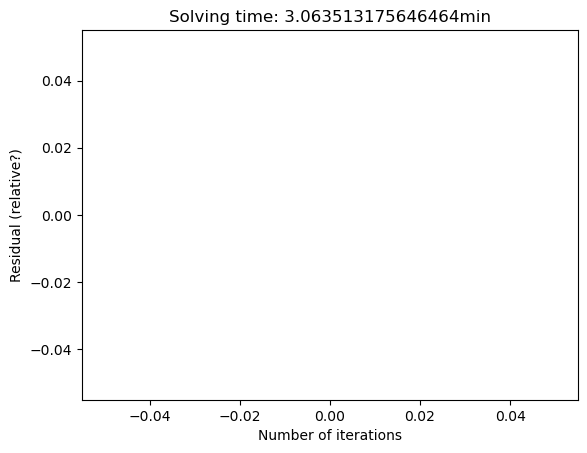

In [39]:
y[0] = CV._vessels.ep['q'].a.max() * cIn
with gmres_counter(1) as callback:
    x, code = spl.gmres(A, y, tol=1e-12, maxiter=4000, callback=callback)
    print("Exited with code", code)
del A, y, K
# x = spl.spsolve(K,y)
cv, ct = x[:nCV], x[nCV:]

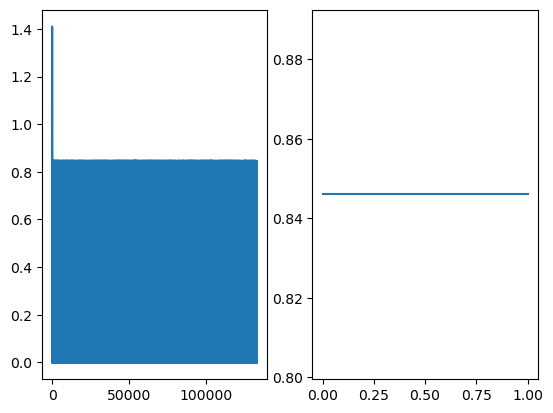

In [40]:
fig, (ax1,ax2) = plt.subplots(1,2)
# _ = ax1.hist(cv)
ax1.plot(cv/alpha)
ax2.plot(np.linspace(0, 1, nz, endpoint=True), ct.reshape((nx,ny,nz))[int(nx/2), int(ny/2), :]/alpha)
plt.show()


### Schurr Complement solver

In [41]:
from LinearSystems import MakeCouplingMatrices, MakeAll

In [42]:
# CV = ControlVolumes(Grid(origin=(cx,cy,cz), 
#                          sideLengths=(lx,ly,lz), 
#                          shape=(nx,ny,nz)), 
#                          vessels=VAG)
SplitVessels(CV, CV.grid.h)
q = CV._vessels.new_edge_property("float", q0) # Flow in the vessel (constant -- conservation of mass)
CV._vessels.ep['q'] = q
C2v, C2t, S = MakeCouplingMatrices(CV, h_v)

Pruning the coupling graph: 100%|██████████| 371394/371394 [00:01<00:00, 210289.57it/s]


In [43]:
from scipy.fftpack import dstn, idstn

def LambdasDirichlet(i, N, h):
    ## Eigenvalues of the 3 points stencil finite differences of 
    # the second order derivatives in 1D
    
    # For Neumann boundary conditions
    # return (2-2*np.cos(i*np.pi/(N+1)))/(h**2)
    return -4*np.sin(i*np.pi/(2*(N)))/(h**2)

def fastPoisson(f, dx,dy,dz, nx,ny,nz):
    dstType = 2
    lambdas = np.sum(
        np.asarray(np.meshgrid(LambdasDirichlet(np.arange(1,nx+1),nx,dx),
                    LambdasDirichlet(np.arange(1,ny+1),ny,dy),
                    LambdasDirichlet(np.arange(1,nz+1),nz,dz),
                    indexing='ij')),
        axis=0)
    u_hat = dstn(f, type=dstType, norm='ortho')/np.where(lambdas==0, np.inf, lambdas)
    u = np.real(idstn(u_hat, type=dstType, norm='ortho'))
    return u

In [44]:
[[A,E],[G,B]], [cvBar, ctBar] = MakeAll(CV, C2v, C2t, S, cIn, ctBC, 
               Gamma_t=Gamma_t, Gamma_v=Gamma_v, h_v=h_v, k_t=k_t)

M, Min, Din = ConvectionMatrices(CV)
A = M + Min # Convection
A += Gamma_v/h_v * C2v.T@S@C2v @ (sp.eye(CV._vessels.num_vertices())-Din)
triSolve = spl.spsolve_triangular
def Sc_func(x):
    '''Schur complement system'''
    return B@x - (G@triSolve(A, E@x)) 
def Make_bc(bv, bt):
    '''Make the bc for the Schur complement system'''
    return bt - G@(triSolve(A, bv))
def cv_func(ct, cvBar):
    return triSolve(A, cvBar - E@ct)

A, done. CPU: svmem(total=67214938112, available=60622860288, percent=9.8, used=5759778816, free=59684503552, active=4824395776, inactive=1294503936, buffers=74596352, cached=1696059392, shared=85331968, slab=744226816)
E, done. CPU: svmem(total=67214938112, available=60622344192, percent=9.8, used=5760294912, free=59683987456, active=4824236032, inactive=1294503936, buffers=74596352, cached=1696059392, shared=85331968, slab=744226816)
Got diffusion. CPU: svmem(total=67214938112, available=60622344192, percent=9.8, used=5760294912, free=59683987456, active=4824260608, inactive=1294503936, buffers=74596352, cached=1696059392, shared=85331968, slab=744226816)
B, done. CPU: svmem(total=67214938112, available=60622344192, percent=9.8, used=5760294912, free=59683987456, active=4824260608, inactive=1294503936, buffers=74596352, cached=1696059392, shared=85331968, slab=744226816)
G, done. CPU, svmem(total=67214938112, available=60622344192, percent=9.8, used=5760294912, free=59683987456, acti

In [45]:
Sc = spl.LinearOperator((CV.grid.size, CV.grid.size), Sc_func)
bc = Make_bc(cvBar, ctBar)

# Preconditionner
P = spl.LinearOperator(shape=Sc.shape, 
                       matvec=lambda x: fastPoisson(x.reshape(CV.grid.n), *CV.grid.h, *CV.grid.n).ravel())

iter   1	rk = 5.818997159755278e-10
iter   2	rk = 2.5325405137244776e-10
iter   3	rk = 1.5303227987672585e-10
iter   4	rk = 9.709236265510503e-11
iter   5	rk = 6.440641056504151e-11
iter   6	rk = 4.056104703984222e-11
iter   7	rk = 2.995023141520266e-11
iter   8	rk = 2.267966120988407e-11
iter   9	rk = 1.8238910166335863e-11
iter  10	rk = 1.381474089881131e-11
iter  11	rk = 1.1041857846413876e-11
iter  12	rk = 9.250914675116557e-12
iter  13	rk = 7.651042169850483e-12
iter  14	rk = 6.117172161907926e-12
iter  15	rk = 4.999875413942687e-12
iter  16	rk = 4.1419381902194485e-12
iter  17	rk = 3.5610931818297084e-12
iter  18	rk = 3.034868243306719e-12
iter  19	rk = 2.61270761856528e-12
iter  20	rk = 2.2252866769447644e-12
iter  21	rk = 2.033717577819416e-12
iter  22	rk = 1.8288572646906436e-12
iter  23	rk = 1.6307708347698833e-12
iter  24	rk = 1.4599176144355638e-12
iter  25	rk = 1.2630037871239674e-12
iter  26	rk = 1.0689940940622768e-12
iter  27	rk = 9.007157409578562e-13
iter  28	rk = 7.6

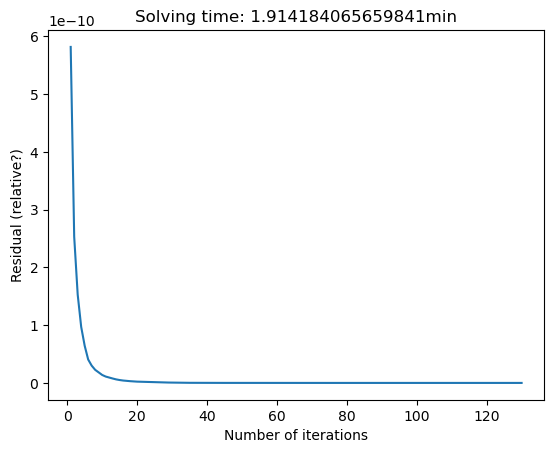

In [46]:
with gmres_counter(disp=1) as callback:
    ct, code = sp.linalg.gmres(Sc, bc, M=P, 
                               tol=1e-8, 
                               callback=callback, maxiter=2000)
    print("Exited with code", code)

cv = cv_func(ct, cvBar)

-11430374449933.34


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


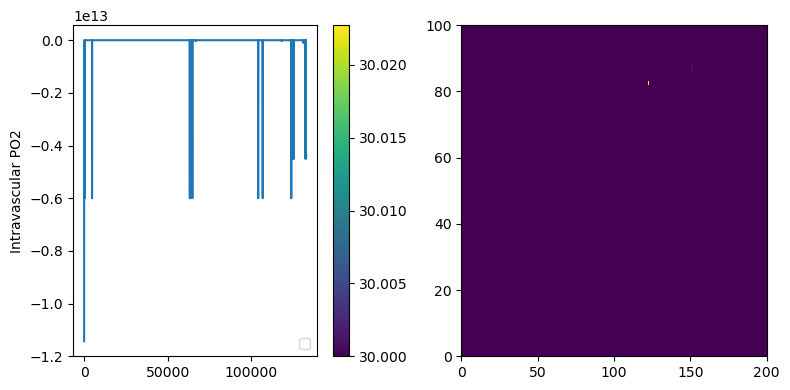

In [47]:
print(cv.min()/alpha)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
s = np.array([np.linalg.norm(CV._vessels.vp['position'][n]) for n in CV._vessels.iter_vertices()])/vy

# ax1.plot(s, xtrue/alpha, label='Exact solution')
ax1.plot((cv/alpha))
# ax1.plot(s*vy, cv/alpha, label='Schurr complement')
# ax1.plot(s*vy, oldcv/alpha, label='Full system')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")

cm = ax2.pcolormesh(ct.reshape(CV.grid.shape)[:, :, int(nz/2)]/alpha)
fig.colorbar(cm, ax=ax1)
fig.tight_layout()
plt.show()